In [109]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Conv1D, TimeDistributed, Dense, Dropout, ReLU, Add
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import joblib

# Load data
data = pd.read_csv("data.csv")
inputs = data.iloc[:, :2].values
output = data.iloc[:, 2].values.reshape(-1, 1)

# Normalize data
scaler_in = MinMaxScaler()
scaler_out = MinMaxScaler()
inputs = scaler_in.fit_transform(inputs)
output = scaler_out.fit_transform(output)

# Save scalers
os.makedirs('scalers', exist_ok=True)
joblib.dump(scaler_in, 'scalers/scaler_in.pkl')
joblib.dump(scaler_out, 'scalers/scaler_out.pkl')

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(inputs, output, test_size=0.2, random_state=42)


In [110]:
# Reshape inputs for LSTM
timesteps = 1
x_train = x_train.reshape((x_train.shape[0], timesteps, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], timesteps, x_val.shape[1]))

# Define TCN block
def tcn_block(x, filters, dilation_rate):
    conv1 = Conv1D(filters, kernel_size=3, padding="causal", dilation_rate=dilation_rate)(x)
    conv1 = ReLU()(conv1)
    conv1 = Dropout(0.2)(conv1)
    conv2 = Conv1D(filters, kernel_size=3, padding="causal", dilation_rate=dilation_rate)(conv1)
    conv2 = ReLU()(conv2)
    conv2 = Dropout(0.2)(conv2)
    shortcut = Conv1D(filters, kernel_size=1, padding="same")(x)
    return Add()([conv2, shortcut])

# Define LSTM-TCN model
input_layer = Input(shape=(timesteps, x_train.shape[2]))
x = LSTM(256, return_sequences=True)(input_layer)
x = LSTM(128, return_sequences=True)(x)
x = LSTM(64, return_sequences=True)(x)

# Apply TCN blocks
x = tcn_block(x, filters=64, dilation_rate=1)
x = tcn_block(x, filters=64, dilation_rate=2)
x = tcn_block(x, filters=64, dilation_rate=4)

# Final output layer
x = TimeDistributed(Dense(1))(x)
output_layer = Dense(1)(x)

# Build and compile model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])


In [111]:
# Train model
history = model.fit(x_train, y_train, epochs=10, batch_size=200, validation_data=(x_val, y_val))

# Evaluate model with metrics
predictions = model.predict(x_val).flatten()
y_val = y_val.flatten()

rmse = np.sqrt(mean_squared_error(y_val, predictions))
mae = mean_absolute_error(y_val, predictions)
r2 = r2_score(y_val, predictions)

print(f"Validation RMSE: {rmse}, Validation MAE: {mae}, Validation R²: {r2}")


Epoch 1/10
418/418 [==============================] - 13s 14ms/step - loss: 0.0231 - mae: 0.0997 - val_loss: 0.0076 - val_mae: 0.0698
Epoch 2/10
418/418 [==============================] - 3s 8ms/step - loss: 0.0069 - mae: 0.0610 - val_loss: 0.0060 - val_mae: 0.0582
Epoch 3/10
418/418 [==============================] - 4s 8ms/step - loss: 0.0067 - mae: 0.0593 - val_loss: 0.0060 - val_mae: 0.0556
Epoch 4/10
418/418 [==============================] - 3s 8ms/step - loss: 0.0063 - mae: 0.0571 - val_loss: 0.0056 - val_mae: 0.0533
Epoch 5/10
418/418 [==============================] - 3s 8ms/step - loss: 0.0063 - mae: 0.0566 - val_loss: 0.0056 - val_mae: 0.0564
Epoch 6/10
418/418 [==============================] - 4s 8ms/step - loss: 0.0062 - mae: 0.0563 - val_loss: 0.0058 - val_mae: 0.0572
Epoch 7/10
418/418 [==============================] - 4s 9ms/step - loss: 0.0062 - mae: 0.0561 - val_loss: 0.0060 - val_mae: 0.0563
Epoch 8/10
418/418 [==============================] - 3s 8ms/step - loss: 

In [112]:
# Create TCNmodel folder
folder_name = 'TCNmodel'
os.makedirs(folder_name, exist_ok=True)
# 保存模型
model_path = os.path.join(folder_name, 'lstm_tcn_model.h5')
model.save(model_path)

print(f"Model saved to {model_path}")


Model saved to TCNmodel/lstm_tcn_model.h5


/root/miniconda3/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


损失图已保存到: lstmtcn_fig/lstm_loss_plot.png
局部放大损失图已保存到: lstmtcn_fig/zoom_loss_plot.png


/tmp/ipykernel_81244/1853266622.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


结合图已保存到: lstmtcn_fig/combined_plot_zoomed.png


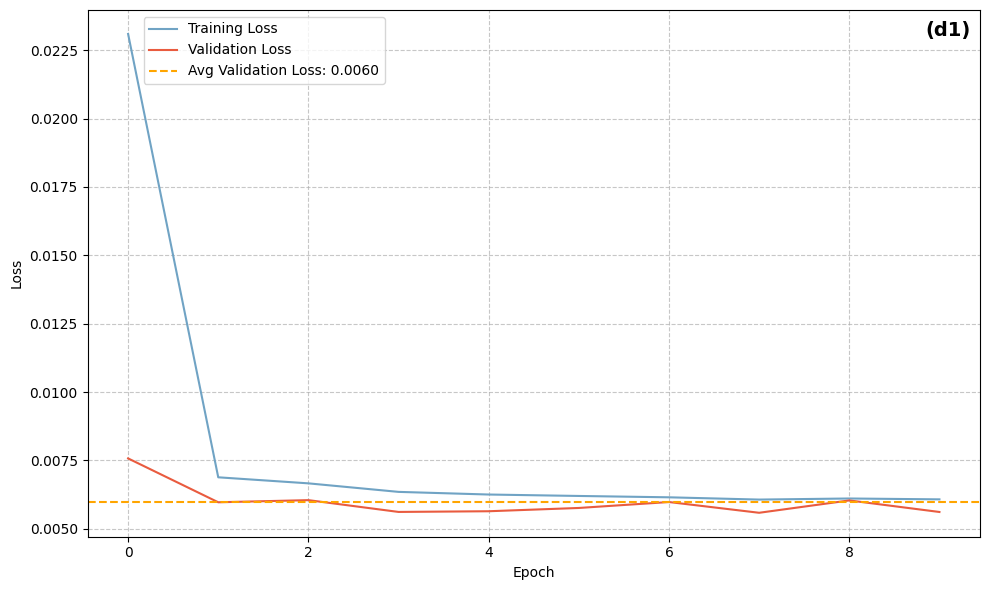

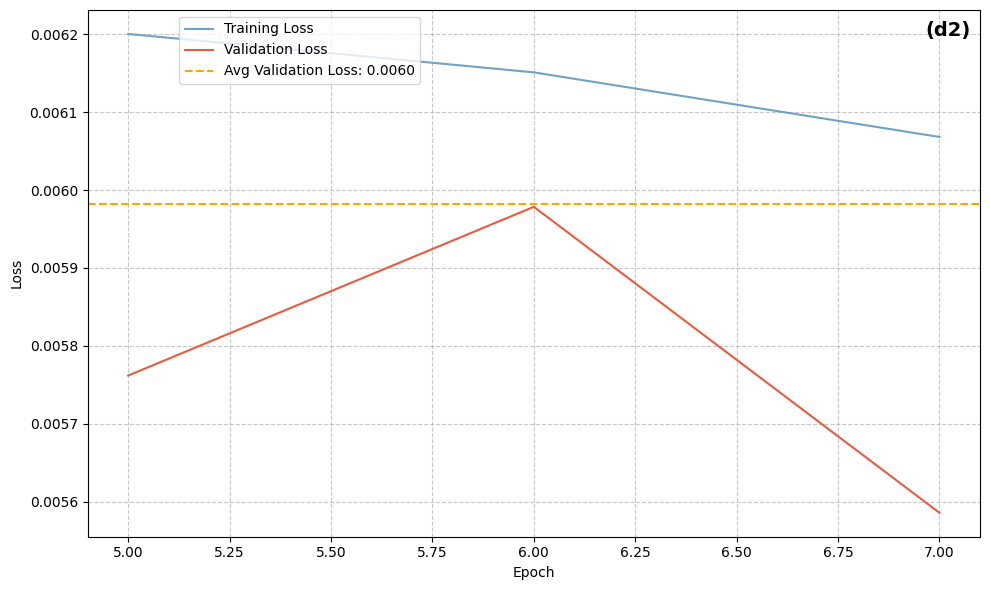

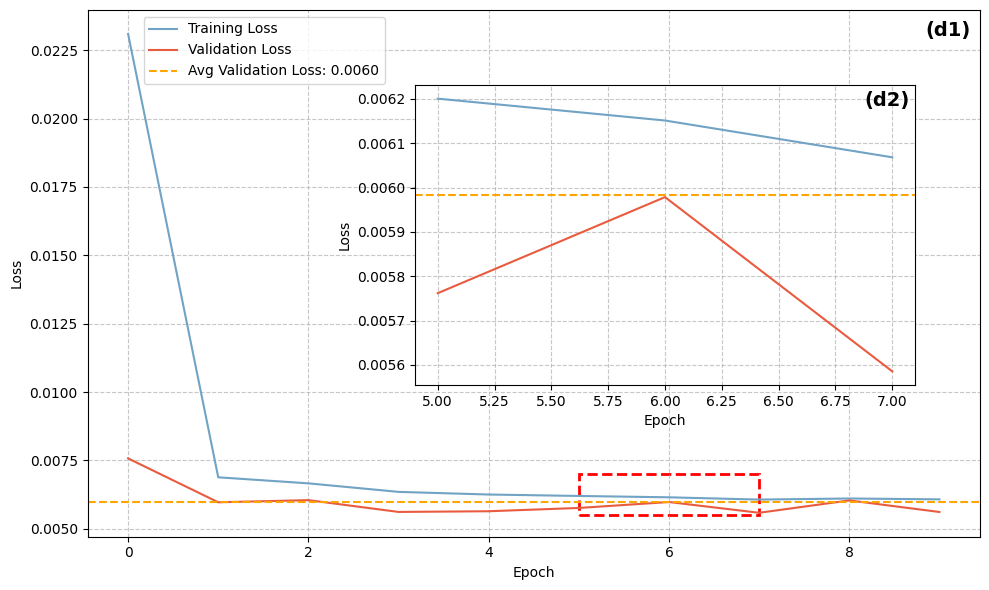

In [123]:
import matplotlib.pyplot as plt
# Plot training and validation MAE
train_mae = history.history['mae']
val_mae = history.history['val_mae']

# Plot training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Calculate average validation loss and MAE
avg_val_loss = np.mean(val_loss)
avg_val_mae = np.mean(val_mae)

# Create folder for saving plots
folder_name = "lstmtcn_fig"
os.makedirs(folder_name, exist_ok=True)

# Plot loss
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(train_loss, color='#70A3C4', label='Training Loss')
ax1.plot(val_loss, color='#E95B3F', label='Validation Loss')
ax1.axhline(y=avg_val_loss, color='#FFA500', linestyle='--', label=f'Avg Validation Loss: {avg_val_loss:.4f}')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left', bbox_to_anchor=(0.055, 1), bbox_transform=ax1.transAxes)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.text(0.99, 0.98, '(d1)', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
plt.tight_layout()
loss_file_path = os.path.join(folder_name, 'lstm_loss_plot.png')
plt.savefig(loss_file_path, dpi=300, bbox_inches='tight')
print(f"损失图已保存到: {loss_file_path}")

# 手动定义红框区域
red_box_start = 5
red_box_end = 7
red_box_y_min =0.0055
red_box_y_max = 0.007

# 手动定义放大区域
zoom_epoch_start = 5
zoom_epoch_end = 8

# Plot zoomed-in loss
fig, ax2 = plt.subplots(figsize=(10, 6))
ax2.plot(range(zoom_epoch_start, zoom_epoch_end), train_loss[zoom_epoch_start:zoom_epoch_end], color='#70A3C4', label='Training Loss')
ax2.plot(range(zoom_epoch_start, zoom_epoch_end), val_loss[zoom_epoch_start:zoom_epoch_end], color='#E95B3F', label='Validation Loss')
ax2.axhline(y=avg_val_loss, color='#FFA500', linestyle='--', label=f'Avg Validation Loss: {avg_val_loss:.4f}')
ax2.legend(loc='upper left', bbox_to_anchor=(0.095, 1), bbox_transform=ax2.transAxes)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.text(0.99, 0.98, '(d2)', transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
plt.tight_layout()
zoom_loss_file_path = os.path.join(folder_name, 'zoom_loss_plot.png')
plt.savefig(zoom_loss_file_path, dpi=300, bbox_inches='tight')
print(f"局部放大损失图已保存到: {zoom_loss_file_path}")

# Plot combined with zoomed-in inset
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(train_loss, color='#70A3C4', label='Training Loss')
ax1.plot(val_loss, color='#E95B3F', label='Validation Loss')
ax1.axhline(y=avg_val_loss, color='#FFA500', linestyle='--', label=f'Avg Validation Loss: {avg_val_loss:.4f}')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left', bbox_to_anchor=(0.055, 1), bbox_transform=ax1.transAxes)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.text(0.99, 0.98, '(d1)', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

# Inset zoomed-in loss
inset_ax = fig.add_axes([0.42, 0.35, 0.5, 0.5])
inset_ax.plot(range(zoom_epoch_start, zoom_epoch_end), train_loss[zoom_epoch_start:zoom_epoch_end], color='#70A3C4')
inset_ax.plot(range(zoom_epoch_start, zoom_epoch_end), val_loss[zoom_epoch_start:zoom_epoch_end], color='#E95B3F')
inset_ax.axhline(y=avg_val_loss, color='#FFA500', linestyle='--')
inset_ax.set_xlabel('Epoch')
inset_ax.set_ylabel('Loss')
inset_ax.grid(True, linestyle='--', alpha=0.7)
inset_ax.text(0.99, 0.98, '(d2)', transform=inset_ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
# 添加红色虚线矩形
rect = plt.Rectangle((red_box_start, red_box_y_min),  # 起始位置 (x, y)
                     red_box_end - red_box_start,  # 宽度
                     red_box_y_max - red_box_y_min,  # 高度
                     edgecolor='red', linestyle='--', linewidth=2, facecolor='none', transform=ax1.transData)
ax1.add_patch(rect)  # 确保将矩形添加到 ax1

plt.tight_layout()
combined_file_path = os.path.join(folder_name, 'combined_plot_zoomed.png')
plt.savefig(combined_file_path, dpi=300, bbox_inches='tight')
print(f"结合图已保存到: {combined_file_path}")

# Show plots
plt.show()

79/79 [==============================] - 1s 3ms/step


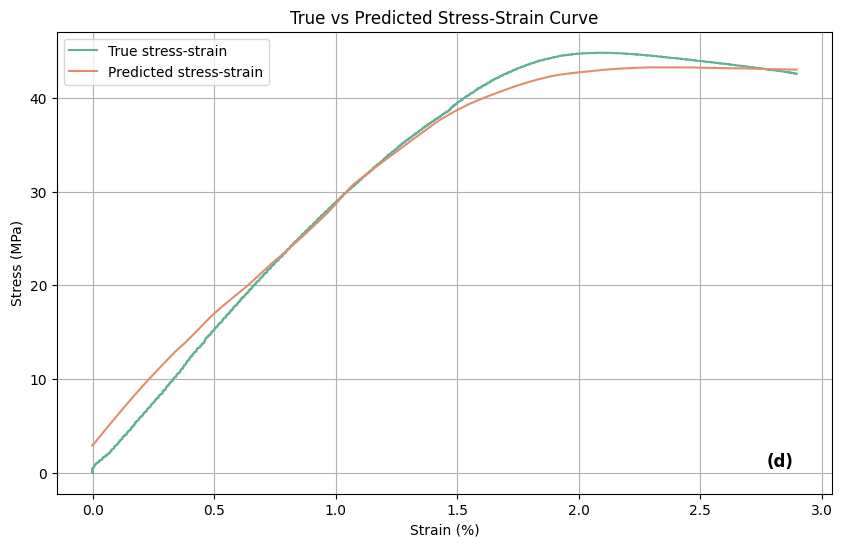

In [124]:
from tensorflow.keras.models import load_model, Model

# 确保保存图片的文件夹存在
folder_path = os.path.join('lstmtcn_fig', 'prediction')
os.makedirs(folder_path, exist_ok=True)

# 加载保存的scaler
scaler_in = joblib.load('scalers/scaler_in.pkl')
scaler_out = joblib.load('scalers/scaler_out.pkl')

# 读取新数据
file_name = 'Angle_group_5.csv'
df_new_data = pd.read_csv(file_name)

# 提取特征和真实值
strain = df_new_data.iloc[:, 1].values  # 假设第二列是应变值
stress_true = df_new_data.iloc[:, 2].values  # 第三列为真实应力值

# 对新数据进行归一化处理
x_new = df_new_data.iloc[:, :2].values  # 取前两列作为输入特征
x_new_scaled = scaler_in.transform(x_new)

# 创建新数据序列
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

sequence_length = 1  # 根据之前的模型设置
x_new_seq = create_sequences(x_new_scaled, sequence_length)

# 加载模型
model_path = os.path.join('TCNmodel', 'lstm_tcn_model.h5')
model = load_model(model_path)

# 进行预测
y_pred_scaled = model.predict(x_new_seq)

# 将预测值从三维转换为二维
y_pred_scaled_2d = y_pred_scaled.reshape(-1, y_pred_scaled.shape[-1])

# 将预测值逆归一化，恢复到原始尺度
stress_pred = scaler_out.inverse_transform(y_pred_scaled_2d).flatten()

# 确保预测值和实际值的长度相同
min_length = min(len(strain), len(stress_pred))
strain_truncated = strain[:min_length]
stress_true_truncated = stress_true[:min_length]
stress_pred_truncated = stress_pred[:min_length]

# 过滤应变值小于或等于2.9的数据
mask = strain_truncated <= 2.9
strain_filtered = strain_truncated[mask]
stress_true_filtered = stress_true_truncated[mask]
stress_pred_filtered = stress_pred_truncated[mask]

# 绘制预测结果与真实值的对比图
plt.figure(figsize=(10, 6))
plt.plot(strain_filtered, stress_true_filtered, label='True stress-strain', color='#62B197')
plt.plot(strain_filtered, stress_pred_filtered, label='Predicted stress-strain', color='#E18E6D')
plt.xlabel('Strain (%)')
plt.ylabel('Stress (MPa)')
plt.legend()
plt.title('True vs Predicted Stress-Strain Curve')
plt.grid(True)
# 在右下角添加文本 (d)
plt.text(0.95, 0.05, '(d)', fontsize=12, fontweight='bold', ha='right', va='bottom', transform=plt.gca().transAxes)

# 保存图片
plt.savefig(os.path.join(folder_path, 'predicted_vs_true_stress_strain.png'))
plt.show()


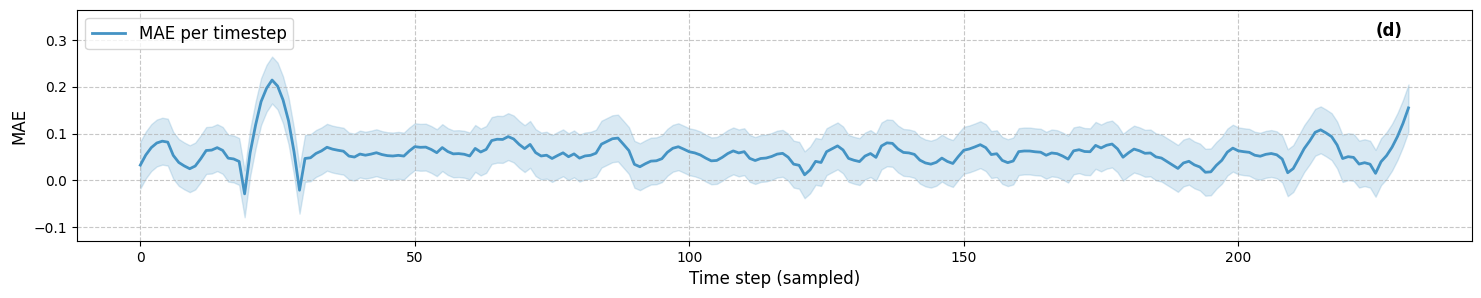

MAE per timestep plot saved and displayed: ./lstmtcn_fig/mae_per_timestep.png


In [115]:
from scipy.signal import savgol_filter

# 假设 y_test_seq 和 y_pred 是你的测试数据和预测结果
# 这里我们使用 y_val 和 predictions 作为示例
y_test_seq = y_val.reshape(-1, 1)  # 确保 y_test_seq 是二维的
y_pred = predictions.reshape(-1, 1)  # 确保 y_pred 是二维的

# 计算每个时间步的 MAE
mae_per_timestep = np.abs(y_test_seq - y_pred).mean(axis=1)

# 采样数据以减少密度（例如，每隔90个点取一个）
sampling_rate = 90
mae_sampled = mae_per_timestep[::sampling_rate]

# 确保 window_length 小于或等于数据长度，并且是奇数
window_length = min(11, len(mae_sampled))
if window_length % 2 == 0:
    window_length -= 1

# 如果 window_length 仍然大于数据长度，调整为数据长度的最大奇数
if window_length < 3:
    window_length = 3

# 平滑曲线（使用 Savitzky-Golay 滤波器）
polyorder = 2  # 确保 polyorder 小于 window_length
mae_smoothed = savgol_filter(mae_sampled, window_length, polyorder)


# 绘制 MAE 随时间变化的图
plt.figure(figsize=(18, 3))
plt.plot(mae_smoothed, label='MAE per timestep', color='#4493C4', linewidth=2)

# 添加跟随曲线变化的窄色条
offset = 0.05  # 设置窄色条的宽度
plt.fill_between(range(len(mae_smoothed)), mae_smoothed - offset, mae_smoothed + offset, color='#4493C4', alpha=0.2)

# 设置图例位置为左上角
plt.legend(loc='upper left', fontsize=12)

# 在右上角添加文本
plt.text(0.95, 0.95, '(d)', fontsize=12, fontweight='bold', ha='right', va='top', transform=plt.gca().transAxes)

plt.xlabel('Time step (sampled)', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
# 设置Y轴范围
plt.ylim(min(mae_smoothed) - 0.1, max(mae_smoothed) + 0.15)

# 保存图像
mae_timestep_path = './lstmtcn_fig/mae_per_timestep.png'
plt.savefig(mae_timestep_path, dpi=300, bbox_inches='tight')

# 显示图像
plt.show()

# 关闭当前图形以释放内存
plt.close()

print(f"MAE per timestep plot saved and displayed: {mae_timestep_path}")
